# CSCA-5642: Final Project #
#### Develop an spatial-temporal sequence classifier to recognize action from video clips. ####
    
* Author: Alexander Meau  
* Email: alme9155@colorado.edu  
* GitHub: [https://github.com/alme9155/csca-5642-final-project/blob/main](https://github.com/alme9155/csca-5642-final-project/blob/main)


<img src="https://www.turing.ac.uk/sites/default/files/inline-images/Action%20recognition%20path%20signature.png" width="600">


## I. Brief description of the problem and data ##

This project explores the application of deep neural networks for human action recognition (HAR) in video sequences. Human action recognition has a wide range of practical applications, including sports analytics, robotics, and surveillance systems. By leveraging architectures such as 3D Convolutional Networks, this study aims to compare the effectiveness of different algorithmic designs. Key challenges include modeling long-term temporal dependencies and handling variations in video length, lighting conditions, and resolution.

### Dataset: ####
* The UCF50 dataset is a collection of video clips, such as Baseball pitch, kayaking, diving, etc created by the University of Central Florida, Center for Research in Computer Vision. 
* The UCF50 dataset is a reduced dataset from the original 101 action categories database.
* Ref: [https://www.crcv.ucf.edu/data/UCF101.php](https://www.crcv.ucf.edu/data/UCF101.php).
  
### Data Size and Dimension ####
* Dataset: Total 6999 avi files acrsso 50 categories.
* Each category has an average of 100-170 .avi video files (average ~133 per category).
* Most of the video clips are in the same resolutions (width=320 x height=240 x channel=3)
* Video lengths varies in temporal resolution (frames per second).
* Videos includes various viewpoints, scales, camera motion, and lighting conditions, making it a challenging dataset for action recognition tasks. 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

category_counts = {}
input_path = '/kaggle/input/ucf50-latest-version/UCF50/'
for dirname, _, filenames in os.walk(input_path):
    avi_file_count = sum(1 for f in filenames if f.endswith('.avi'))
    
    if avi_file_count > 0:
        category_name = os.path.basename(dirname)
        category_counts[category_name] = avi_file_count

df_counts = pd.DataFrame(list(category_counts.items()), columns=['Category', '# AVI Files'])
df_counts = df_counts.sort_values(by='# AVI Files', ascending=False).reset_index(drop=True)
display(df_counts)
print(f"\nTotal .avi file count = {df_counts['# AVI Files'].sum()}")
print(f"Average .avi file count = {df_counts['# AVI Files'].mean()}")


,Category,# AVI Files
0,HorseRiding,197
1,TennisSwing,167
2,Drumming,161
3,BenchPress,160
4,PoleVault,160
5,Punch,160
6,PlayingGuitar,160
7,Kayaking,157
8,SoccerJuggling,156
9,Diving,153



Total .avi file count = 6669
Average .avi file count = 133.38


## II. Exploratory Data Analysis (EDA) ##
- Examine video quality:
  - Dimension (width x height)
  - Frame Count and Frame per secound
  - Total count of video clips
  - Total count of video category

In [2]:
import os
import cv2
import pandas as pd
from collections import defaultdict


dataset_root = '/kaggle/input/ucf50-latest-version/UCF50/'
video_profile_stats = defaultdict(lambda: {'Video Count': 0, 'Category Count': set()})
for root, _, files in os.walk(dataset_root):
    for file in files:
        if file.endswith('.avi'):
            video_path = os.path.join(root, file)
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                continue

            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration = round(frame_count / fps, 1) if fps > 0 else 0
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            resolution = f"{width}x{height}"
            category = os.path.basename(os.path.dirname(video_path))
            #key = (resolution, round(fps, 2), frame_count, duration)
            ret, frame = cap.read()
            channel =1
            if ret and frame is not None and len(frame.shape) == 3:
                channel = frame.shape[2]
            key = (resolution, round(fps, 2), frame_count, duration, channel)
            
            # Accumulate count
            video_profile_stats[key]['Video Count'] += 1
            video_profile_stats[key]['Category Count'].add(category)
            cap.release()

# Convert to DataFrame
summary_rows = []
for key, stats in video_profile_stats.items():
    resolution, fps, frame_count, duration, channel = key
    video_count = stats['Video Count']
    category_count = len(stats['Category Count'])
    summary_rows.append({
        'Resolution': resolution,
        'Frame per sec': fps,
        'Frame Count': frame_count,
        'Duration in sec': duration,
        'Channels': channel,
        'Video Count': video_count,
        'Category Count': category_count
    })

print("\nAccumulated Video Stats Summary:\n")
df_summary = pd.DataFrame(summary_rows).sort_values(by='Video Count', ascending=False).reset_index(drop=True)
display(df_summary)


Accumulated Video Stats Summary:



,Resolution,Frame per sec,Frame Count,Duration in sec,Channels,Video Count,Category Count
0,320x240,25.00,300,12.0,3,275,9
1,320x240,29.97,240,8.0,3,256,7
2,320x240,25.00,250,10.0,3,171,8
3,320x240,29.97,201,6.7,3,101,10
4,320x240,25.00,168,6.7,3,64,15
...,...,...,...,...,...,...,...
827,320x240,29.97,624,20.8,3,1,1
828,320x240,29.97,390,13.0,3,1,1
829,320x240,29.97,447,14.9,3,1,1
830,320x240,29.97,589,19.7,3,1,1


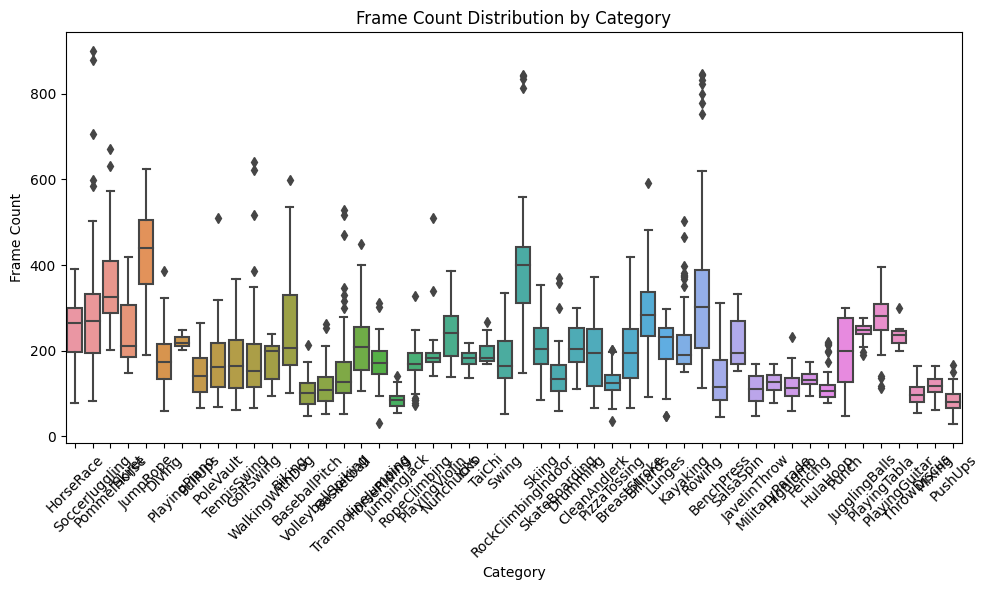

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

category_stats = []
for key, stats in video_profile_stats.items():
    resolution, fps, frame_count, duration, channel = key
    input_shape = f"{frame_count}x{height}x{width}x3"  
    for category in stats['Category Count']:
        category_stats.append({
            'Category': category,
            'Resolution': resolution,
            'Frame per sec': fps,
            'Frame Count': frame_count,
            'Duration in sec': duration,
            'Channels': channel,
            'Input Shape': input_shape,
            'Video Count': stats['Video Count'],  # shared across all category entries here
        })

df_category_stats = pd.DataFrame(category_stats)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_category_stats, x='Category', y='Frame Count')
plt.xticks(rotation=45)
plt.title("Frame Count Distribution by Category")
plt.tight_layout()
plt.show()

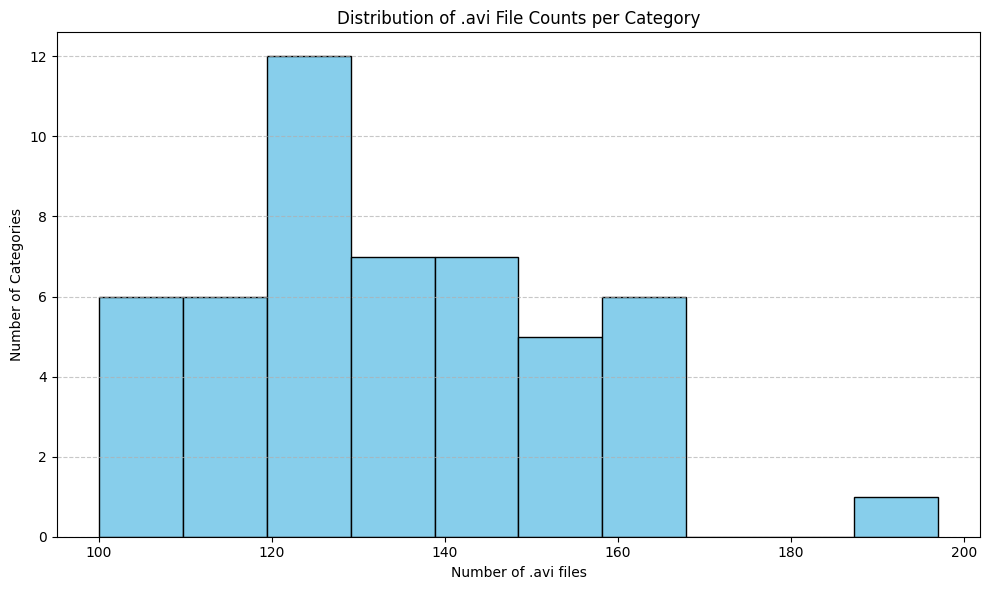

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.hist(df_counts['# AVI Files'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of .avi File Counts per Category')
plt.xlabel('Number of .avi files')
plt.ylabel('Number of Categories')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## III. EDA Summary and Analysis ##

### Summary ###
* The dataset contains ~7,000 .avi video files (exactly 6,669) across 50 action categories.
  * Most categories contain between 110 and 150 video clips.
  * There is no extreme class imbalance in terms of video count per category.
* Almost all of the videos has same spatial size and color format.
  * Width x Height x Channel = 320 x 240 x 3
* There are large variation in frame count.
  * Frame count ranges from 58 to 641.
  * Some categories has total frames > 500-800. (e.g. Jump Rope, Horse Race)
  * Other categories stay under < 150 frames (e.g. Push Ups)
  * Many action categories contain significant outliers in frame count.

### Analysis ###
* Due to the volume of dataset, and the limited GPU quotas on Kaggle platform, **2 video categories** have been selected to reduce the input dataset.
 * 2 selected video categories:
    * **'Basketball', 'PushUps'**
 * Reducing the input dataset can help reduce training time.

* Even though the input dataset is reduced to less number .avi files to process, data preparation is still required to **standardize video input** shape before applying deep learning model.
* **Spatial Dimension**:
  *  Deep learning model expect fixed input shapes in the form: (Frames × Height × Width × Channels)
  *  The OpenCV library returns images in BGR, but most pre-trained models expect RGB format.
  *  Although the clips are in consistent dimensions (320×240×3), it is best to resize to **112×112×3**
      *  Reducing the spatial dimensions helps lower memory usage and improves processing speed.
      *  Pre-trained models such as R(2+1)D and C3D are designed to operate on 112×112x3 inputs.
* **Temporal Dimension**:
  * Most pre-trained video classifier required fixed-length input in the range of 16-64 frames.
  * Uniform sampling to a **32-frame** clip length provides a good balance for our dataset.
  * For clip <32 frames, clips are padded with the last frame is used to reach the standard length.
  * For clip >32 frames, clips are split into multiple overlapping chunks of the standard length.

* Ref: [https://openaccess.thecvf.com/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf](https://openaccess.thecvf.com/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf)

## IV. Video Files Standardization ##

Prepare video files into uniform format to be consumed by video classification.
* Spatial dimension conversion:
  * Resize avi files dimension from 320(width) x 240(height) to 128 (width)x171(height)
  * Center crop fil to 112(width) x 112(height)
  * ensure files loaded from OpenCV from BGR to RGB format
* Temporal conversion:
  * Clip video files into chunks of 32 frames
* Serialize video chunks into TensorFlow TFRecord files.


In [1]:
# Common constants
BASE_DIR = '/kaggle/input/ucf50-latest-version/UCF50/'
TFRECORD_DIR = '/kaggle/working/ucf50-tfrec'
NUMPY_DIR = '/kaggle/working/ucf50-npy'
# SAMPLE_CATEGORIES = [
#     'HighJump', 'Basketball', 'TennisSwing', 'PullUps', 'PushUps',
#     'JumpingJack', 'SkateBoarding', 'TrampolineJumping', 'Lunges', 'GolfSwing'
# ]
SAMPLE_CATEGORIES = ['Basketball', 'PushUps']

print(NUMPY_DIR)
print(SAMPLE_CATEGORIES)

/kaggle/working/ucf50-npy
['Basketball', 'PushUps']


In [2]:
### III.i Data Pre-processing ###
import os
import shutil

def clean_up_output_dir(): 
    if not os.path.exists(NUMPY_DIR):
        os.makedirs(NUMPY_DIR, exist_ok=True)
        print(f"Output directory '{NUMPY_DIR}' created.")
    else:
        for subdir in os.listdir(NUMPY_DIR):
            full_path = os.path.join(NUMPY_DIR, subdir)
            if os.path.isdir(full_path):
                shutil.rmtree(full_path) 
        print(f"All files and subdirectory under '{NUMPY_DIR}' removed.")
        #os.makedirs(NUMPY_DIR, exist_ok=True)
        #print(f"Output directory '{NUMPY_DIR}' re-created.")
    
clean_up_output_dir()
print('Output Clean-up complete')

All files and subdirectory under '/kaggle/working/ucf50-npy' removed.
Output Clean-up complete


In [3]:
import os
import cv2
import numpy as np

# Constants
RESIZE_DIM = (128, 171)   # Resize first to this size
CROP_SIZE = 112           # Then center crop to this
NUM_FRAMES = 32           # Temporal length
STRIDE = 16               # Used for chunking long videos

def standardize_video_with_spatial_conversion(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    for _ in range(total_frames):
        success, frame = cap.read()
        if not success:
            break
        frame = cv2.resize(frame, RESIZE_DIM)

        # Center crop manually (corrected redundancy)
        h, w = frame.shape[:2]
        start_h = (h - CROP_SIZE) // 2
        start_w = (w - CROP_SIZE) // 2
        frame = frame[start_h:start_h + CROP_SIZE, start_w:start_w + CROP_SIZE]

        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        frames.append(frame)

    cap.release()
    return frames  # list of (112x112x3) numpy arrays

def standardize_video_with_temporal_conversion(frames):
    chunks = []
    if not frames:
        return [] 
    if len(frames) < NUM_FRAMES:
        # Pad with last frame
        padded = frames + [frames[-1]] * (NUM_FRAMES - len(frames))
        chunks.append(np.array(padded, dtype=np.uint8))
    else:
        # Break into overlapping chunks
        for i in range(0, len(frames) - NUM_FRAMES + 1, STRIDE):
            chunk = frames[i:i + NUM_FRAMES]
            chunks.append(np.array(chunk, dtype=np.uint8))
    return chunks
print('Spatial and Temporal conversion method defined..')

Spatial and Temporal conversion method defined..


In [5]:
import os
import numpy as np
from tqdm import tqdm

def save_as_numpy_example(clip, label, output_dir, category, count):
    sample = {
        'video': clip.astype(np.uint8),  # or np.float32 depending on storage needs
        'label': np.int32(label)
    }
    filename = os.path.join(output_dir, f"{category}_{count:05d}.npy")
    np.save(filename, sample)


def preprocess_videos_to_npy():
    label_map = {cls: idx for idx, cls in enumerate(SAMPLE_CATEGORIES)}
    for category in SAMPLE_CATEGORIES:
        category_path = os.path.join(BASE_DIR, category)
        output_category_dir = os.path.join(NUMPY_DIR, category)  
        os.makedirs(output_category_dir, exist_ok=True)

        count = 0
        for filename in tqdm(os.listdir(category_path), desc=f'Processing {category}'):
            if not filename.endswith('.avi'):
                continue

            video_path = os.path.join(category_path, filename)
            converted_frames = standardize_video_with_spatial_conversion(video_path)
            converted_chunks = standardize_video_with_temporal_conversion(converted_frames)

            for clip in converted_chunks:
                save_as_numpy_example(clip, label_map[category], output_category_dir, category, count)
                count += 1
preprocess_videos_to_npy()
print('video pre-processed and saved as .npy complete.')

Processing PushUps: 100%|██████████| 106/106 [00:03<00:00, 33.09it/s]

video pre-processed and saved as .npy complete.


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No su

Category: Basketball, NPY File Count: 983
/kaggle/working/ucf50-npy/Basketball/Basketball_00654.npy


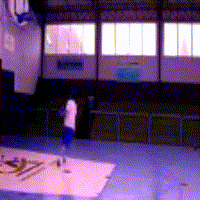

Category: PushUps, NPY File Count: 388
/kaggle/working/ucf50-npy/PushUps/PushUps_00138.npy


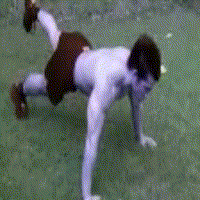

Total .npy video files: 1371.
Display of sample .npy videos complete.


In [7]:
import os
import warnings
import tempfile
import numpy as np
from IPython.display import Image, display
from moviepy.editor import ImageSequenceClip
import random
import cv2

warnings.filterwarnings('ignore')
if 'XDG_RUNTIME_DIR' not in os.environ:
    os.environ['XDG_RUNTIME_DIR'] = '/tmp/runtime-dir'
    os.makedirs(os.environ['XDG_RUNTIME_DIR'], exist_ok=True)

# Update this with your correct numpy directory and categories
NUMPY_DIR = '/kaggle/working/ucf50-npy'
SAMPLE_CATEGORIES = ['Basketball', 'PushUps']


def video_array_to_gif(video_array):
    try:
        with tempfile.NamedTemporaryFile(suffix='.gif', delete=False) as tmp_file:
            gif_filename = tmp_file.name

        if video_array.dtype != np.uint8:
            video_array = np.clip(video_array, 0, 255).astype(np.uint8)
        resized_frames = [cv2.resize(frame, (200, 200)) for frame in video_array]
        clip = ImageSequenceClip(resized_frames, fps=10)
        clip.write_gif(gif_filename, program='ffmpeg', logger=None)
        clip.close()
        return gif_filename

    except Exception as e:
        print(f"GIF creation error: {e}")
        return None



# Loop through each category and show one sample video
total_npy_count = 0
for category in SAMPLE_CATEGORIES:
    category_path = os.path.join(NUMPY_DIR, category)
    if not os.path.isdir(category_path):
        continue

    # Only load video files that end with '_video.npy'
    video_files = [f for f in os.listdir(category_path) if f.endswith('.npy')]
    count = len(video_files)
    total_npy_count += count
    print(f"Category: {category}, NPY File Count: {count}")

    if count > 0:
        sample_video_file = os.path.join(category_path, random.choice(video_files))
        print(sample_video_file)
        data = np.load(sample_video_file, allow_pickle=True).item()
        video_np = data['video'] 

        gif_file = video_array_to_gif(video_np)
        if gif_file and os.path.exists(gif_file):
            display(Image(filename=gif_file))
            os.remove(gif_file)

print(f"Total .npy video files: {total_npy_count}.")
print("Display of sample .npy videos complete.")


## V. Model Architecture ##

### Model Description ###

This model implements 3D Conventional Neural Network for video classification.
- **Input shape**: (batch_size=4, 32, 112, 112, 3)
    - temporal depth 32
    - spatial 112×112 RGB
- **Layers**:
    - Conv3D -> MaxPool3D -> Dropout (×3)
    - Flatten -> Dense(256) -> Dropout -> Dense(10 softmax)
- **Output**:
    - 10 categories
- **(Dropout)**:
    - training=True/False based on call()
- **Batch Size**
    - default batch size is set to 4, which should fit the memory boundary of GPU P100

### Key Design ###
-  Model Init method accept two set of hyper-parameters
    - **filters**: Number of filter in the Convolutional 3D layers
    - **droputs**: Variable Dropout rates 
- Unlike 2D CNN network, 3D Convolutional Neural Network use a cube filter to capture both spatial (Height x Width x Channel) and temporal dimension (**Time**).
- This model accept tensor input of (batch_size x height x width x channel x frames)
- Base Model begins with flat 32 filters on all 3 stacks of Conv3D with dropout rate=0.5
- During hyper-parameter tuning, we will experiment with ascending value of filter [32, 64, 128]
- Then, we will experiment with ascending dropout rate [0.3, 0.4, 0.5]

#### Reference ###
- Ref: [https://www.tensorflow.org/tutorials/video/video_classification](https://www.tensorflow.org/tutorials/video/video_classification)

<img src="https://www.tensorflow.org/images/tutorials/video/3DCNN.png" width="600">

In [3]:
import os
import tensorflow as tf
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')
print(tf.__version__)

2.18.0


In [3]:
import tensorflow as tf
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os
import tensorflow as tf
import warnings
import keras
from keras import layers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')


# During data-preprocessing step, we have limited dataset to 10 categories.
OUTPUT_CLASS = 2

# Custom Conv3D Model Class
class VideoActionClassifier(tf.keras.Model):
    """
    A flexible 3-layer Conv3D-based video classifier.
    Accepts variable filters and dropout rates for hyper-parameter tuning.
    Input shape: (batch, frames, height, width, channels)
    """    
    def __init__(self, filters, dropouts):
        super(VideoActionClassifier, self).__init__()

        self.model_layers = [
            layers.Conv3D(filters[0], kernel_size=(3, 3, 3), activation='relu', padding='same'),
            layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2)),
            layers.Dropout(dropouts[0]),

            layers.Conv3D(filters[1], kernel_size=(3, 3, 3), activation='relu', padding='same'),
            layers.MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2)),
            layers.Dropout(dropouts[1]),

            layers.Conv3D(filters[2], kernel_size=(3, 3, 3), activation='relu', padding='same'),
            layers.MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2)),
            layers.Dropout(dropouts[2]),

            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(OUTPUT_CLASS, activation='softmax')
        ]

    def call(self, x, training=False):
        for layer in self.model_layers:
            if isinstance(layer, layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x

# Hyper-parameters
dropout_base_model = [0.3, 0.3, 0.3]
filter_base_model = [32, 32, 32]

# Batch size configuration
BATCH_SIZE = 4  # Safe for 32x112x112x3x4 ~ 80MB RAM, fits P100 GPU

# Base model
base_model = VideoActionClassifier(filters=filter_base_model, 
                                   dropouts=dropout_base_model)
base_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
base_model.build(input_shape=(None, 32, 112, 112, 3))  
base_model.save('conv3d_base_model.h5') 
base_model.summary()  
print('base model complete....')

I0000 00:00:1753771579.366584      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "video_action_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

base model complete....


In [5]:
import os
import glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

SPLIT_RATIO = [0.7, 0.15, 0.15]
BATCH_SIZE = 4
SEED = 42
NUMPY_DIR = '/kaggle/working/ucf50-npy'

# Extract idx from numpy file
def get_all_paths_and_labels():
    paths, labels = [], []
    categories = sorted([d for d in os.listdir(NUMPY_DIR) if os.path.isdir(os.path.join(NUMPY_DIR, d))])
    label_map = {cat: idx for idx, cat in enumerate(categories)}

    for category in categories:
        category_path = os.path.join(NUMPY_DIR, category)
        npy_files = sorted(glob.glob(os.path.join(category_path, '*.npy')))  # <-- SORT HERE

        for file in npy_files:
            paths.append(file)
            labels.append(label_map[category])

    # Sort all file paths and labels together
    sorted_pairs = sorted(zip(paths, labels), key=lambda x: x[0])
    sorted_paths, sorted_labels = zip(*sorted_pairs)
    return list(sorted_paths), list(sorted_labels)

def load_sample(path):
    path = path.numpy().decode('utf-8')
    sample = np.load(path, allow_pickle=True).item()
    return sample['video'], sample['label']

def tf_wrapper(path):
    video, label = tf.py_function(load_sample, [path], [tf.float32, tf.int32])
    video.set_shape([32, 112, 112, 3])
    label.set_shape([])
    return video, label

def make_dataset(paths):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

paths, labels = get_all_paths_and_labels()
train_filepaths, temp_paths, train_labels, temp_labels = train_test_split(
    paths, labels, test_size=(1 - SPLIT_RATIO[0]), random_state=SEED, stratify=labels)

validate_filepaths, test_filepaths, validate_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=SPLIT_RATIO[2] / (SPLIT_RATIO[1] + SPLIT_RATIO[2]),
    random_state=SEED, stratify=temp_labels)

train_ds = make_dataset(train_filepaths)
val_ds = make_dataset(validate_filepaths)
test_ds = make_dataset(test_filepaths)

print(f"Train Dataset: {len(train_filepaths)}")
print(f"Validate Dataset: {len(validate_filepaths)}")
print(f"Test Dataset: {len(test_filepaths)}")
print("Dataset loading complete...")


Train Dataset: 959
Validate Dataset: 206
Test Dataset: 206
Dataset loading complete...


In [5]:
import tensorflow as tf
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os
import tensorflow as tf
import warnings
import pickle

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')

PATIENCE_VALUE = 3
EPOCHS = 10
early_stop = callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=PATIENCE_VALUE, 
                                     restore_best_weights=True)
checkpoint_base_model = callbacks.ModelCheckpoint('best_model.h5', 
                                                  save_best_only=True, 
                                                  monitor='val_accuracy')

history_base_model = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_base_model]
)

with open("history_base_model.pkl", "wb") as f:
    pickle.dump(history_base_model.history, f)

test_loss_base_model, test_acc_base_model = base_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc_base_model:.4f}")


Epoch 1/10


I0000 00:00:1753770884.322061      97 service.cc:148] XLA service 0x7e7edc2b0350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753770884.322819      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753770884.740810      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/240 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.3125 - loss: 238.3675   

I0000 00:00:1753770890.854199      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


240/240 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.6430 - loss: 90.5056 - val_accuracy: 0.8544 - val_loss: 0.3018
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.8358 - loss: 1.0868 - val_accuracy: 0.9078 - val_loss: 0.2590
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.8491 - loss: 0.4001 - val_accuracy: 0.8883 - val_loss: 0.2390
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.9007 - loss: 0.2875 - val_accuracy: 0.8981 - val_loss: 0.2190
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.9129 - loss: 0.2465 - val_accuracy: 0.8301 - val_loss: 0.3516
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9038 - loss: 0.2873 - val_accuracy: 0.9466 - val_loss: 0.1896
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.9569 - loss: 0.1256 - val_accuracy: 0.9320 - val_loss: 0.2105
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.9619 - loss: 0.1283 - val_accura

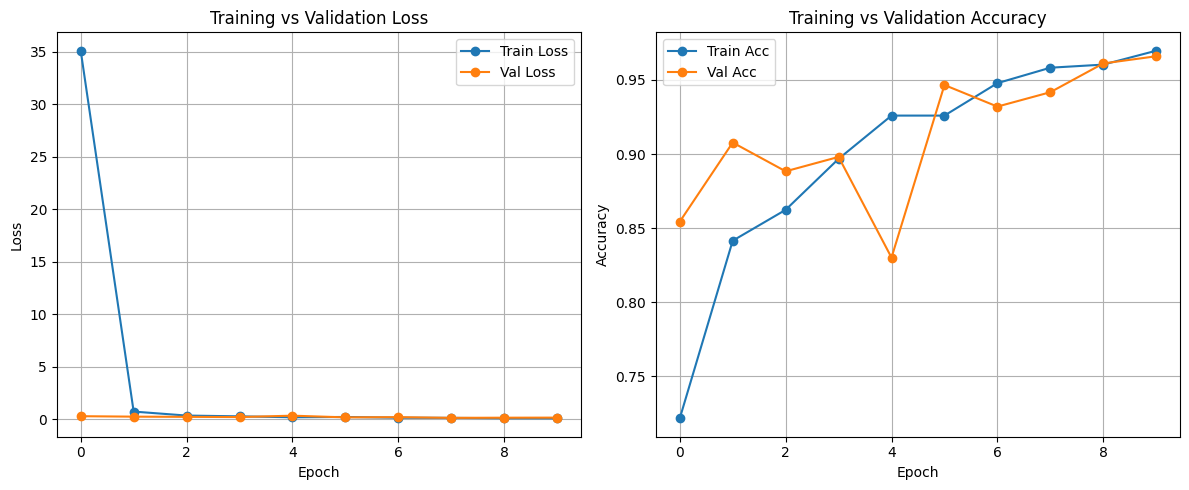

In [6]:
import matplotlib.pyplot as plt
import pickle

with open("history_base_model.pkl", "rb") as f:
    history_base_model = pickle.load(f)
    
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_base_model['loss'], label='Train Loss', marker='o')
plt.plot(history_base_model['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_base_model['accuracy'], label='Train Acc', marker='o')
plt.plot(history_base_model['val_accuracy'], label='Val Acc', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

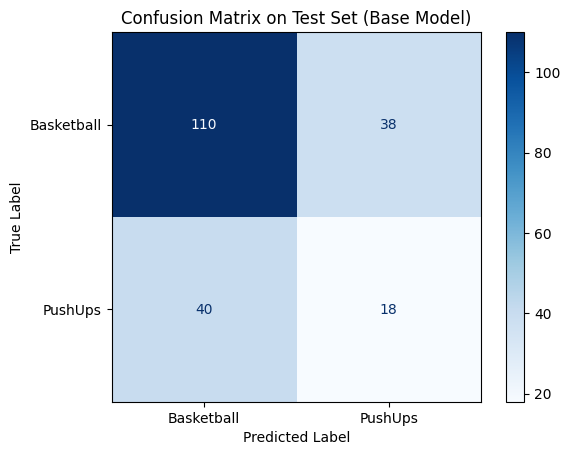

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SAMPLE_CATEGORIES = ['Basketball', 'PushUps']
y_pred_base_model = np.argmax(base_model.predict(test_ds, verbose=0), axis=1)
y_true_base_model = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)

cm_base_model = confusion_matrix(y_true_base_model, y_pred_base_model, labels=[0, 1])
disp_base_model = ConfusionMatrixDisplay(confusion_matrix=cm_base_model,
                                         display_labels=SAMPLE_CATEGORIES)
plt.figure(figsize=(10, 8))
disp_base_model.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set (Base Model)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

## VI. Base Model Prediction Result Analysis ##
- Final Test Accuracy: ~96.2%
- From Confusion Matrix:
  - Basketball: 110 correct, 38 misclassified as PushUps
  - PushUps: 18 correct, 40 misclassified as Basketball
- Training and validation accuracy improves steadily with epochs.
- Some fluctuation in validation accuracy suggests potential instability.


### Interpretation: ###
- Balanced performance on both training and validation sets suggests no sign of overfitting.
- The confusion matrix reveals a bias toward correctly predicting Basketball.
- The model struggles with PushUps recall due to limited spatial movement contrast.


### Tuning Opportunities: ###
- **Dropout Strategy**: Experiment with descending dropout rates to help deeper layers retain more features.
- **Filters**: Experiment with progressively deeper filters to capture more complex spatial-temporal patterns.
- **Alternative Architecture**: Separate spatial from temporal features.

## VII. Hyper-parameter Fine-Tuning by Increasing Number of Filters ##

* In this experiment, we adopt the same Conv3D architecture but vary the number of filters across layers:
  - Base Model has uniform filters: (32, 32, 32))
  - New Model will have ascending num of filters:  (32, 64, 128)

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pickle

progressive_filters = [32, 64, 128]
progressive_dropouts = [0.3, 0.3, 0.3]

PATIENCE_VALUE = 3
EPOCHS = 10

# Tuned filters only
model_filter_tuning = VideoActionClassifier(filters=progressive_filters, 
                                            dropouts=dropout_base_model)
model_filter_tuning.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model_filter_tuning.build(input_shape=(None, 32, 112, 112, 3))  
model_filter_tuning.save('conv3d_model_filter_tuning.h5') 
# model_filter_tuning.summary()  

checkpoint_filter_tuning = callbacks.ModelCheckpoint('conv3d_model_filter_tuning.h5', 
                                       save_best_only=True, monitor='val_accuracy')
early_stop = callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=PATIENCE_VALUE, 
                                     restore_best_weights=True)

history_filter_tuning = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_filter_tuning]
)

with open("history_filter_tuning.pkl", "wb") as f:
    pickle.dump(history_filter_tuning.history, f)

test_loss_filter_tuning, test_acc_filter_tuning = model_filter_tuning.evaluate(test_ds)
print(f"Test Accuracy: {test_acc_filter_tuning:.4f}")


Epoch 1/10


I0000 00:00:1753771667.973534      90 service.cc:148] XLA service 0x7d7bb82af310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753771667.974201      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753771668.394942      90 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/240 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.2500 - loss: 101.9260       

I0000 00:00:1753771674.480198      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


240/240 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step - accuracy: 0.6830 - loss: 97.6342 - val_accuracy: 0.6942 - val_loss: 0.5296
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - accuracy: 0.8069 - loss: 0.7640 - val_accuracy: 0.7913 - val_loss: 0.4710
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.8424 - loss: 0.4844 - val_accuracy: 0.6893 - val_loss: 0.4981
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.8698 - loss: 0.3413 - val_accuracy: 0.8301 - val_loss: 0.4255
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.8851 - loss: 0.2811 - val_accuracy: 0.8786 - val_loss: 0.3653
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9194 - loss: 0.1985 - val_accuracy: 0.9223 - val_loss: 0.3424
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.9526 - loss: 0.1615 - val_accuracy: 0.9175 - val_loss: 0.2549
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.9078 - loss: 0.2298 - val_accura

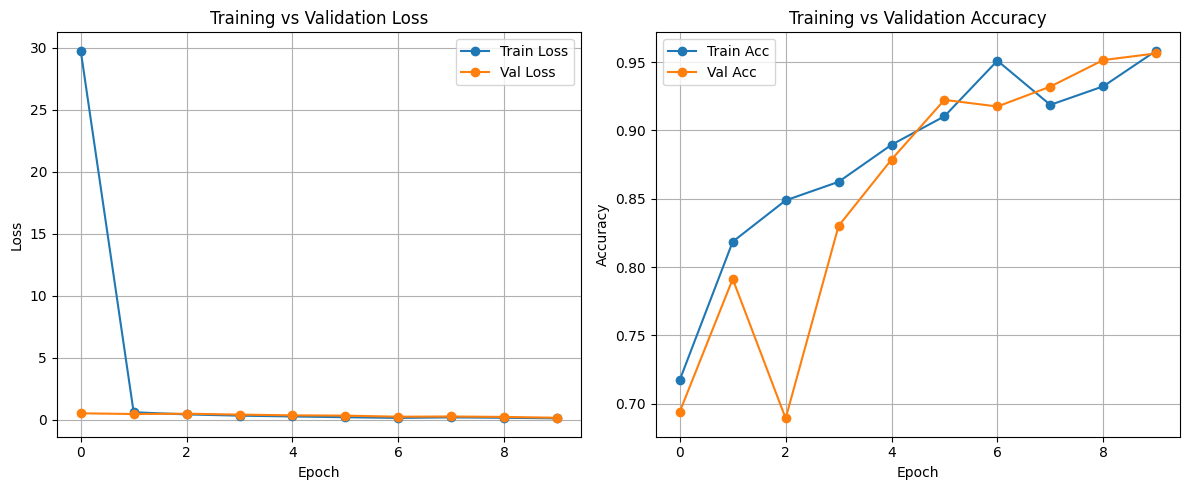

In [6]:
import matplotlib.pyplot as plt
import pickle

with open("history_filter_tuning.pkl", "rb") as f:
    history_filter_tuning = pickle.load(f)
    
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_filter_tuning['loss'], label='Train Loss', marker='o')
plt.plot(history_filter_tuning['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_filter_tuning['accuracy'], label='Train Acc', marker='o')
plt.plot(history_filter_tuning['val_accuracy'], label='Val Acc', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

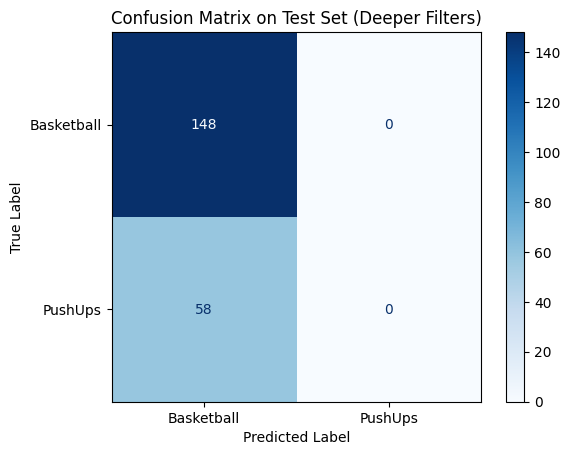

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SAMPLE_CATEGORIES = ['Basketball', 'PushUps']
y_true_filter_tuning = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)
y_pred_filter_tuning = np.argmax(model_filter_tuning.predict(test_ds, verbose=0), axis=1)

cm_filter_tuning = confusion_matrix(y_true_filter_tuning, y_pred_filter_tuning, labels=[0, 1])
disp_filter_tuning = ConfusionMatrixDisplay(confusion_matrix=cm_filter_tuning,
                                            display_labels=SAMPLE_CATEGORIES)
plt.figure(figsize=(10, 8))
disp_filter_tuning.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set (Deeper Filters)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

## VIII. Prediction Results and Interpretation with Ascending Number of Filters ##
- Conclusion: **Deeper Filters Didn’t Yield Better Results.**
### Result ###
- Excellent recognition of the dominant or more visually distinct class (Basketball).
- Completely failed to detect the minority class (PushUps).
### Interpretation ###
- The deeper model has significantly more parameters, increasing the risk of memorizing the training data rather than generalizing.
- If dropout rate or weight decay wasn't adjusted alongside increasing filters, the model may have overfit quickly.

## IX. Hyper-parameter Fine-Tuning by Decreasing Number of Dropouts ##

* Base model with uniform drop-out rate carries risk of over-regularization of deeper layers.
* In this model, we will adopt the same Conv3D architecture with descending dropout rate:
  - Base Model has uniform drop-out rate: (0.3, 0.3, 0.3)
  - New Model will have descending drop-out rate: (0.3, 0.2, 0.1)

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pickle

progressive_filters = [32, 64, 128]
progressive_dropouts = [0.3, 0.2, 0.1]

PATIENCE_VALUE = 3
EPOCHS = 10

# Tuned dropout only
model_dropout_tuning = VideoActionClassifier(filters=progressive_filters, 
                                            dropouts=progressive_dropouts)
model_dropout_tuning.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model_dropout_tuning.build(input_shape=(None, 32, 112, 112, 3))  
model_dropout_tuning.save('conv3d_model_filter_tuning.h5') 
# model_dropout_tuning.summary()  

checkpoint_dropout_tuning = callbacks.ModelCheckpoint('conv3d_model_dropout_tuning.h5', 
                                       save_best_only=True, monitor='val_accuracy')
early_stop = callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=PATIENCE_VALUE, 
                                     restore_best_weights=True)

history_dropout_tuning = model_dropout_tuning.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_dropout_tuning]
)
with open("history_dropout_tuning.pkl", "wb") as f:
    pickle.dump(history_dropout_tuning.history, f)

test_loss_dropout_tuning, test_acc_dropout_tuning = model_dropout_tuning.evaluate(test_ds)
print(f"Test Accuracy: {test_acc_dropout_tuning:.4f}")


Epoch 1/10


I0000 00:00:1753769873.614749      99 service.cc:148] XLA service 0x7bd53c0062c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753769873.615291      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753769874.041513      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-29 06:17:58.027369: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,32,56,56]{4,3,2,1,0}, f32[4,64,32,56,56]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-07-29 06:17:58.287

  2/240 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.3750 - loss: 437.6818  

I0000 00:00:1753769881.640640      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


240/240 ━━━━━━━━━━━━━━━━━━━━ 55s 145ms/step - accuracy: 0.6739 - loss: 95.1739 - val_accuracy: 0.7184 - val_loss: 0.4923
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.8634 - loss: 0.3030 - val_accuracy: 0.8835 - val_loss: 0.3784
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.9435 - loss: 0.1772 - val_accuracy: 0.9369 - val_loss: 0.2042
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.9262 - loss: 0.1711 - val_accuracy: 0.9612 - val_loss: 0.1468
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - accuracy: 0.9644 - loss: 0.0976 - val_accuracy: 0.9563 - val_loss: 0.1175
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - accuracy: 0.9696 - loss: 0.0831 - val_accuracy: 0.9806 - val_loss: 0.0989
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 29s 97ms/step - accuracy: 0.9809 - loss: 0.0601 - val_accuracy: 0.9806 - val_loss: 0.1318
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.9682 - loss: 0.0784 - val_a

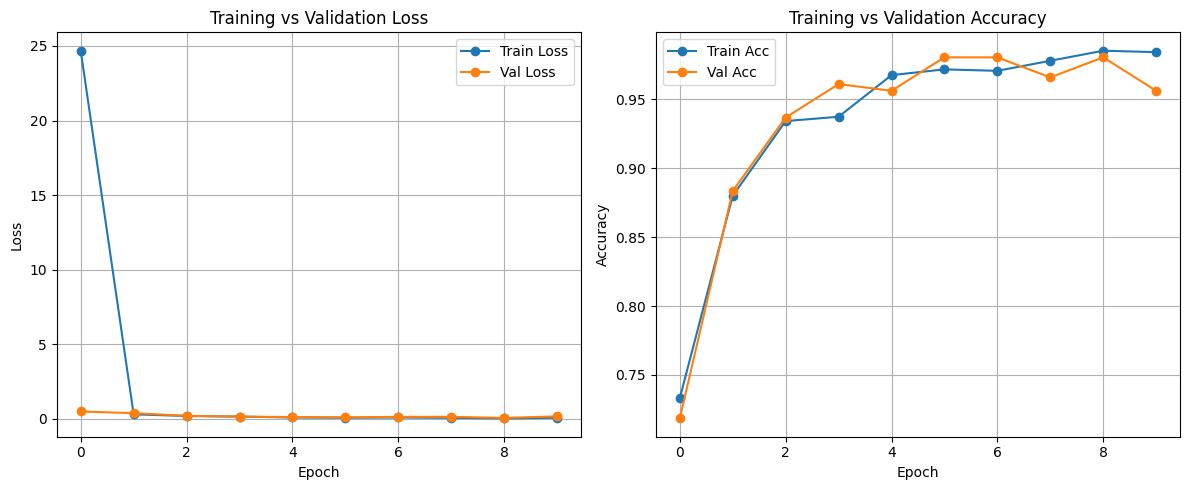

In [9]:
import matplotlib.pyplot as plt
import pickle

with open("history_dropout_tuning.pkl", "rb") as f:
    history_dropout_tuning = pickle.load(f)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dropout_tuning['loss'], label='Train Loss', marker='o')
plt.plot(history_dropout_tuning['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dropout_tuning['accuracy'], label='Train Acc', marker='o')
plt.plot(history_dropout_tuning['val_accuracy'], label='Val Acc', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

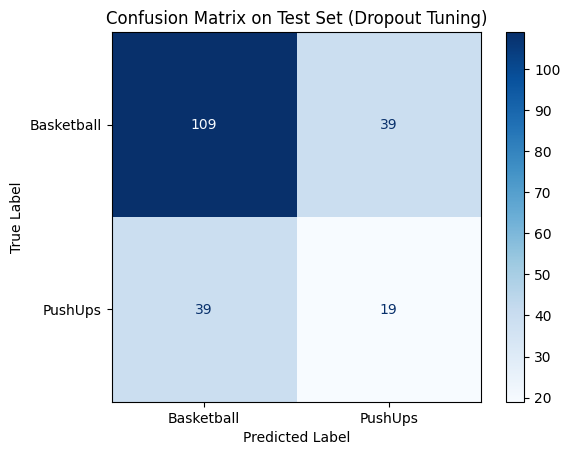

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SAMPLE_CATEGORIES = ['Basketball', 'PushUps']

y_pred_dropout_tuning = np.argmax(model_dropout_tuning.predict(test_ds, verbose=0), axis=1)
y_true_dropout_tuning = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)

cm_dropout_tuning = confusion_matrix(y_true_dropout_tuning, y_pred_dropout_tuning, labels=[0, 1])
disp_dropout_tuning = ConfusionMatrixDisplay(confusion_matrix=cm_dropout_tuning,
                                             display_labels=SAMPLE_CATEGORIES)
plt.figure(figsize=(10, 8))
disp_dropout_tuning.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set (Dropout Tuning)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

## X. Prediction Results and Interpertation with Descending Number of Dropouts ##
- Conclusion: **Increasing number of filters pairing with decreasing number of dropout yield the best prediction.**
### Result ###
- Achieved the highest test accuracy among the three models: 97.09% on the test set.
- Achieved the highest validation accuracy among the three models: 98.06%.
- The confusion matrix shows a high number of true positives for Basketball (109/148 = 73.6%).

### Interpretation ###
- Training and validation curves are tightly aligned, showing no overfitting.
- The model is biased toward predicting Basketball, likely due to its more distinct and dynamic visual cues.

## XI. Explore Different 3D Convolution Model Architectures: Conv2Plus1D ##

Other than using a 3D convolutional network, Tensorflow/Keras also provided (2+1)D convolution network.
- **Conv3D**: Applies a single 3D convolutional kernsl (temporal T x Height H x Width W) : e.g. (3, 3, 3)
- **Conv2Plus1D**: Decomposes the 3D convolution into two sequential operations:
  - 2D spatial convolution (Height H x Width W) : e.g. (1, 3, 3)
  - 1D temporal convolution (2+1) convolution network : e.g. (3, 1, 1)

#### Reference ###
- Ref: [https://www.tensorflow.org/tutorials/video/video_classification](https://www.tensorflow.org/tutorials/video/video_classification)

<img src="https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png" width="600">

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks
import numpy as np
import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

OUTPUT_CLASS = 2 

class Conv2Plus1D(tf.keras.Model):
    """
    Conv(2+1)D video classifier: separates spatial and temporal dimension.
    Ref: https://www.tensorflow.org/tutorials/video/video_classification
    """
    def __init__(self, filters, dropouts):
        super(Conv2Plus1D, self).__init__()

        self.model_layers = []

        for i in range(len(filters)):
            # 2D spatial 
            self.model_layers.append(layers.Conv3D(
                filters[i], kernel_size=(1, 3, 3), padding='same', activation='relu'
            ))
            # 1D temporal
            self.model_layers.append(layers.Conv3D(
                filters[i], kernel_size=(3, 1, 1), padding='same', activation='relu'
            ))
            self.model_layers.append(layers.MaxPool3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))
            self.model_layers.append(layers.Dropout(dropouts[i]))

        self.model_layers += [
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(OUTPUT_CLASS, activation='softmax')
        ]

    def call(self, x, training=False):
        for layer in self.model_layers:
            if isinstance(layer, layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x
print('Conv(2+1)D model complete.')

Conv(2+1)D model complete.


In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pickle

# Evaluate and test model
progressive_filters = [32, 64, 128]
filter_base_model = [32, 32, 32]
progressive_dropouts = [0.3, 0.2, 0.1]
BATCH_SIZE = 4

PATIENCE_VALUE = 3
EPOCHS = 10

conv2plus1_model = Conv2Plus1D(filters=filter_base_model, dropouts=progressive_dropouts)
conv2plus1_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

conv2plus1_model.build(input_shape=(None, 32, 112, 112, 3))
conv2plus1_model.save('conv2plus1d_base_model.h5')
#conv2plus1_model.summary()
print("Conv(2+1)D model compiled and ready.")


checkpoint_conv2plus1 = callbacks.ModelCheckpoint('conv2plus1d_base_model.h5', 
                                       save_best_only=True, monitor='val_accuracy')
early_stop = callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=PATIENCE_VALUE, 
                                     restore_best_weights=True)

history_conv2plus1 = conv2plus1_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_conv2plus1]
)
with open("history_conv2plus1.pkl", "wb") as f:
    pickle.dump(history_conv2plus1.history, f)

test_loss_conv2plus1, test_acc_conv2plus1 = conv2plus1_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc_conv2plus1:.4f}")


Conv(2+1)D model compiled and ready.
Epoch 1/10


I0000 00:00:1753780110.725331      97 service.cc:148] XLA service 0x78d6d800f9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753780110.726181      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753780111.255209      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/240 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.7500 - loss: 15.9622   

I0000 00:00:1753780117.840058      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


240/240 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.6693 - loss: 21.4458 - val_accuracy: 0.8107 - val_loss: 0.4787
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.7811 - loss: 0.5261 - val_accuracy: 0.9029 - val_loss: 0.4506
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8161 - loss: 0.3883 - val_accuracy: 0.8592 - val_loss: 0.3940
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.8658 - loss: 0.3267 - val_accuracy: 0.8689 - val_loss: 0.2987
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.8683 - loss: 0.2923 - val_accuracy: 0.9417 - val_loss: 0.2618
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.8800 - loss: 0.2639 - val_accuracy: 0.9175 - val_loss: 0.2481
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9136 - loss: 0.2109 - val_accuracy: 0.9078 - val_loss: 0.3127
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.9287 - loss: 0.1753 - val_accura

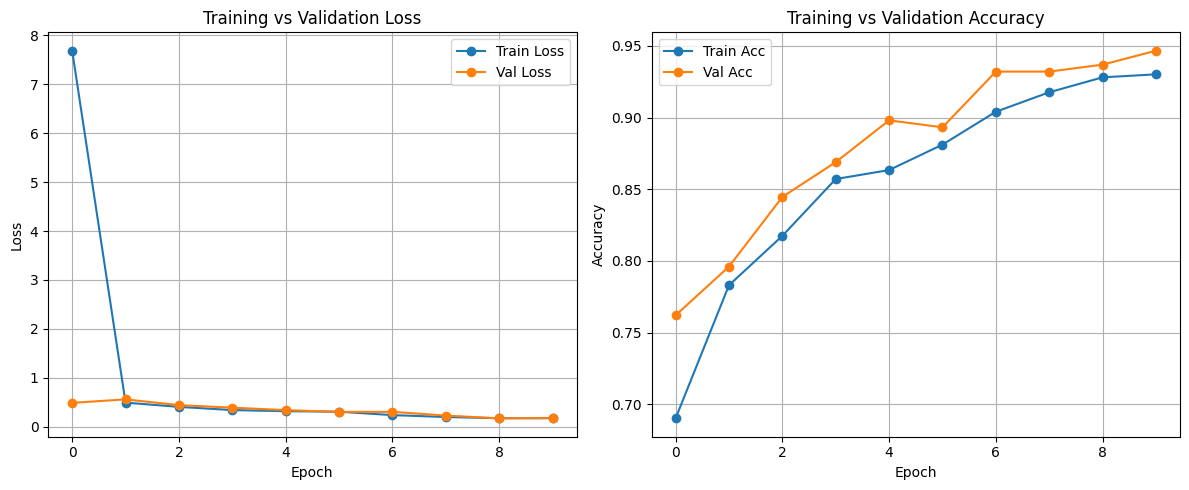

In [12]:
import matplotlib.pyplot as plt
import pickle

with open("history_conv2plus1.pkl", "rb") as f:
    history_conv2plus1 = pickle.load(f)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_conv2plus1['loss'], label='Train Loss', marker='o')
plt.plot(history_conv2plus1['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_conv2plus1['accuracy'], label='Train Acc', marker='o')
plt.plot(history_conv2plus1['val_accuracy'], label='Val Acc', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

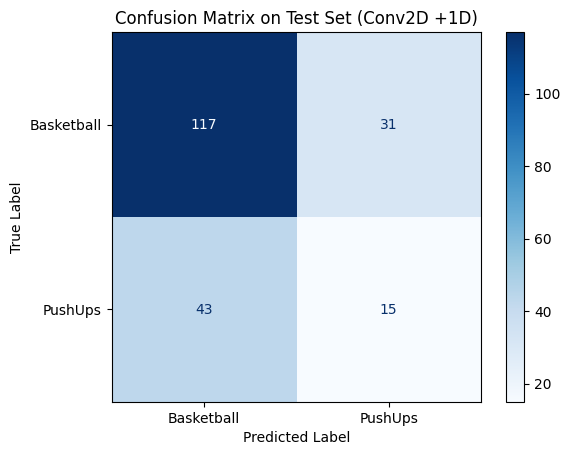

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

SAMPLE_CATEGORIES = ['Basketball', 'PushUps']

y_pred_conv2plus1 = np.argmax(conv2plus1_model.predict(test_ds, verbose=0), axis=1)
y_true_conv2plus1 = np.concatenate([labels.numpy() for _, labels in test_ds], axis=0)

cm_conv2plus1 = confusion_matrix(y_true_conv2plus1, y_pred_conv2plus1, labels=[0, 1])
disp_conv2plus1 = ConfusionMatrixDisplay(confusion_matrix=cm_conv2plus1,
                                             display_labels=SAMPLE_CATEGORIES)
plt.figure(figsize=(10, 8))
disp_conv2plus1.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set (Conv2D +1D)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()

## XII. Performance Analysis with Conv2D+1D Model Architectures ##

- The Conv2D+1D model uses the same number of filters and dropout configuration as the Conv3D model.
  - Conv2D+1D yields lower accuracy on both the validation and test datasets.
  - Conv2D+1D achieves an accuracy of 0.9029, whereas Conv3D achieves 0.9709.

- The Conv2D+1D model predicts Basketball videos more accurately than PushUps.
- Possible interpretation:
  - Basketball contains distinct visual frames that are easier for 2D feature extraction.
  - PushUps rely heavily on temporal motion cues, which the Conv2D+1D model may miss or underrepresent.

## XIII. Conclusion ##

### Best Performance is Achieved with the Following 3D Convolutional Network ###
- Model Architecture: 3 layers of 3D convoluntional layer block + output layer block
- Input shape: (4, 32, 112, 112, 3)
- Kernel shape: (3, 3, 3)
- Each convolution block include Max pooling 3D(2, 2, 2), stride=(2, 2, 2) following dropout layer
- Output class=2 
- Learning rate: default (0.001) with Early stopping

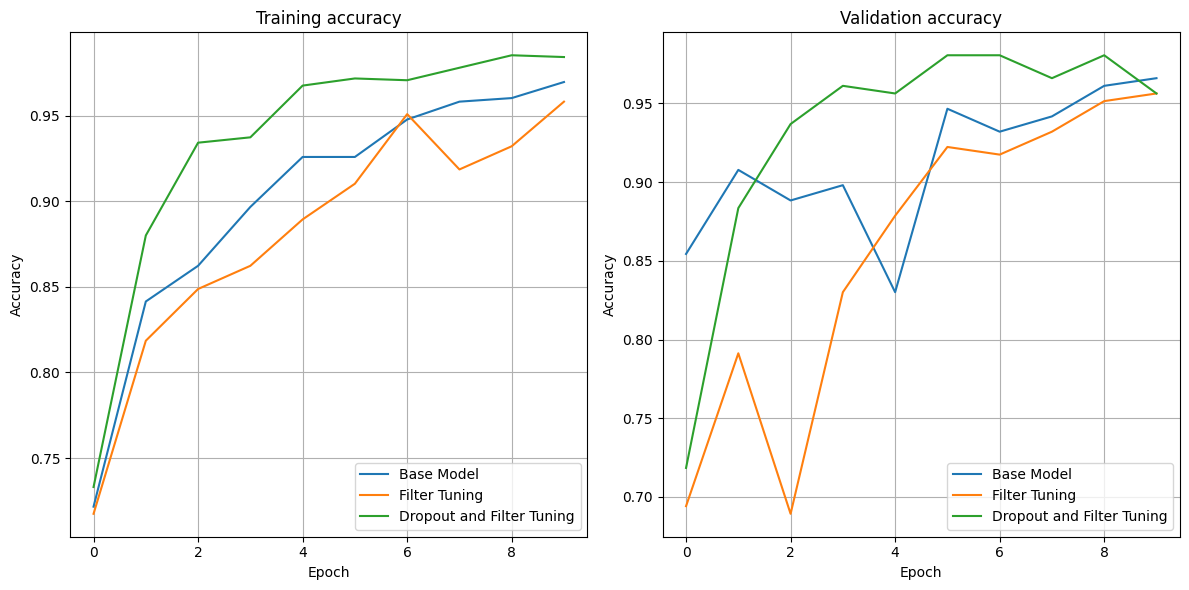

In [1]:
import pickle
import os
import matplotlib.pyplot as plt

OUTPUT_DIR = '/kaggle/working'
history_files = {
    'Base Model': os.path.join(OUTPUT_DIR, 'history_base_model.pkl'),    
    'Filter Tuning': os.path.join(OUTPUT_DIR, 'history_filter_tuning.pkl'),
    'Dropout and Filter Tuning': os.path.join(OUTPUT_DIR, 'history_dropout_tuning.pkl')
}

def load_history(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def plot_model_comparisons(histories, metric='accuracy'):
    plt.figure(figsize=(12, 6))
    
    # Plot training accuracy
    plt.subplot(1, 2, 1)
    for name, hist in histories.items():
        plt.plot(hist[metric], label=f'{name}')
    plt.title(f'Training {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    for name, hist in histories.items():
        val_metric = f'val_{metric}'
        if val_metric in hist:
            plt.plot(hist[val_metric], label=f'{name}')
    plt.title(f'Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

histories = {name: load_history(path) for name, path in history_files.items()}
plot_model_comparisons(histories, metric='accuracy')

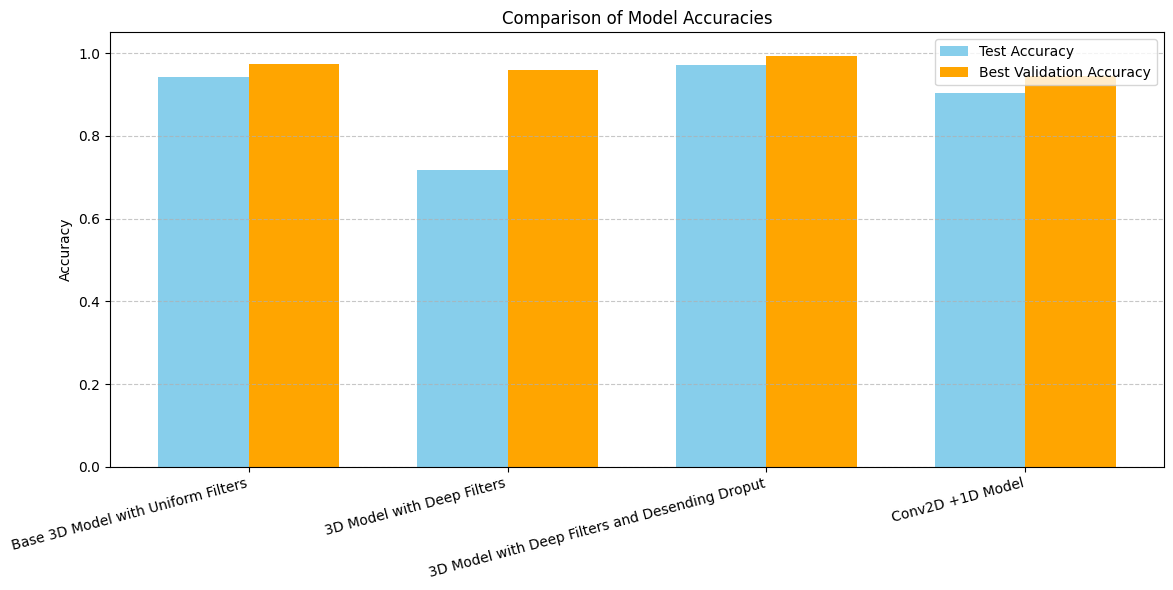

In [8]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

model_test_accuracy = {
    'Base 3D Model with Uniform Filters': 0.9417,    
    '3D Model with Deep Filters': 0.7184,
    '3D Model with Deep Filters and Desending Droput': 0.9709,
    'Conv2D +1D Model': 0.9029
}

best_validation_accuracy = {
    'Base 3D Model with Uniform Filters': 0.9723,    
    '3D Model with Deep Filters': 0.9583,
    '3D Model with Deep Filters and Desending Droput': 0.9922,
    'Conv2D +1D Model': 0.9440
}

model_names = list(model_test_accuracy.keys())
test_accuracies = list(model_test_accuracy.values())
val_accuracies = [best_validation_accuracy[name] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, test_accuracies, width, label='Test Accuracy', color='skyblue')
plt.bar(x + width/2, val_accuracies, width, label='Best Validation Accuracy', color='orange')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(x, model_names, rotation=15, ha='right')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Results ###
- The best Conv3D model balances capacity and generalization by using ascending filter depths and descending dropout rates.
- Best Conv3D is better at identifying Basketball videos, but it misclassify PushUps videos..

**What works?**
- High prediction accuracy on Basketball videos is achieved because they contain strong and distinct motion features, which are easier for the model to capture.

**What doesn't works?**
- PushUps videos have a relatively limited range of motion, leading to a high false-positive rate where they are often misclassified as Basketball.

Metrics:
| Metric               | Formula                          | BasketBall  | PushUps  |
|----------------------|----------------------------------|-----------|-----------|
| Accuracy             | (TP + TN) / (TP + TN + FP + FN) | 0.620  | 0.620  |
| Precision (PPV)      | TP / (TP + FP)                  | 0.736  | 0.327  |
| Recall (Sensitivity) | TP / (TP + FN)                  | 0.736  | 0.328  |
| Specificity          | TN / (TN + FP)                  | 0.327  | 0.736  |
| F1 Score             | 2 * (Precision * Recall) / (Precision + Recall) | 0.736 | 0.327 |

Confusion Matrix:
|                  | Predicted: Basketball | Predicted: PushUps | Total   |
|------------------|--------------------|---------------------|---------|
| **Actual: Basketball** | 109 (≈73.6%) | 39 (≈26.4%)      | 148 (71.8%) |
| **Actual: PushUps** | 39 (≈67.2%)   | 19 (≈32.8%)   | 58 (28.2%) |
| **Total**          | 148 (71.8%)     | 58 (28.2%)         | 206 (100%) |


### What improve the performance of the model? ###

**Best validation and test performance is achieved by balancing generalization and learning capacity**:
- Ascending "Filter" depth allow model to better capture motion features.
- 32 -> 64 -> 128 filters allows:
  - 1st layer of 32 filters capture low-level features, such as edges, motion boundaries.
  - 2nd layer of 64 filters capture combined patterns, such as joint movements.
  - 3rd layer of 128 filters capture most complex movie pattern in video
- Descending "Dropout" regularization stabilitize training.
- 0.3 -> 0.2 -> 0.1 dropout rates allows:
  - 1st layer of 0.3 dropout rate prevent overfitting on simple features.
  - 2nd layer of 0.2 dropout rate keeps more important features.
  - 3rd layer of 0.1 dropout rate keep most important feature intact.
- Good balance is achieved by combining ascending filter depths and descending dropout rate in 3D convolution layers
  - Increase number of filter add learning capability tailor with high drop out rate to guard ovefitting.
  - This model generalizes well from the training to validation and test data.

### Why Convolution 3D networks performs better than Convolution (2D +1D)? ###
- Conv3D kernels operate on both space and time simultanteously.
- Conv3D allow capture motion patterns such as PushUps better than Conv(2D+1D).
- Conv2D+1D is better for specialized learning to seperate spatial and temporal feature seperately.
  
### What improvement could you try in the future? ###
- Experiment with Video Vision Transformer (ViT) with 3D Convolutions [https://arxiv.org/abs/2103.15691](https://arxiv.org/abs/2103.15691)
- Explore with Video Swin Transformer [https://openaccess.thecvf.com/content/CVPR2022/papers/Liu_Video_Swin_Transformer_CVPR_2022_paper.pdf](https://openaccess.thecvf.com/content/CVPR2022/papers/Liu_Video_Swin_Transformer_CVPR_2022_paper.pdf)

## XIV. Future Works and References ##

### Future Works ###
- Multi-Object Detection Model : [https://pytorch.org/hub/ultralytics_yolov5/](https://pytorch.org/hub/ultralytics_yolov5/)
- Occupancy Network : [https://openaccess.thecvf.com/content_CVPR_2019/papers/Mescheder_Occupancy_Networks_Learning_3D_Reconstruction_in_Function_Space_CVPR_2019_paper.pdf](https://openaccess.thecvf.com/content_CVPR_2019/papers/Mescheder_Occupancy_Networks_Learning_3D_Reconstruction_in_Function_Space_CVPR_2019_paper.pdf)
### References ###
- Ref: Video Classification Tutorial : [https://www.tensorflow.org/tutorials/video/video_classification](https://www.tensorflow.org/tutorials/video/video_classification) 
- Ref: Center for Research in Computer Vision : [https://www.crcv.ucf.edu/data/UCF101.php](https://www.crcv.ucf.edu/data/UCF101.php)
- Ref: The Alan Turing Institute: [https://www.turing.ac.uk/research/research-projects/human-action-recognition](https://www.turing.ac.uk/research/research-projects/human-action-recognition)